## notebook for plotting the citation patterns of a single conference

revisions from v0:

* DONE - fix venue name entry: CoRR
* DONE - have venue name indicate conf or journal (-c, -j suffix) 
* DONE - clean up the data structure and groupbys 
* normalize heatmaps, compute entropy
* export one single graph for incoming/outgoing citations
* generate network layout for the graph above
* DONE - auto save and name the plots

processing

* figs for PLDI
* figs for ML conferences
* figs for ACM MM

* new MAG data


In [14]:
import os, sys
import pandas as pd
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle

# initilize plotting packages: seaborn

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

%matplotlib inline

#conf = 'WSDM'
conf = 'PLDI'
data_dir = './data'
plot_dir = './plots'

input data: 

* dataframes: paper, citing, cited
* conference + journal --> df_venue, displaynames

In [15]:
d = pickle.load( open(os.path.join(data_dir, 'cite_records.'+conf+".pkl"), 'rb') )
# pickle.dump({"name":c, 'citing':dfx_citing, "cited":dfx_cited, "paper":df_paper}, 
#           open(os.path.join(data_dir, 'cite_records.'+c+".pkl"), 'wb') ) 

df_citing = d['citing']
df_cited = d['cited']
df_paper = d['paper']

print(len(df_paper), len(df_citing), len(df_cited))

1171 22040 49083


In [16]:
conf_file = os.path.join(data_dir, 'Conferences.txt')
conf_df = pd.read_table(conf_file, header=None, names=['ConfID', 'Abbrv', 'FullName'])

jnl_file = os.path.join(data_dir, 'Journals.txt')
jnl_df = pd.read_table(jnl_file, header=None, names=['JournalID', 'FullName'])

print("{} conferences and {} journals found in db".format(len(conf_df), len(jnl_df)) )

num_conf = len(conf_df)

df_venue = pd.concat([ conf_df[['ConfID', 'Abbrv']].rename(columns = {'Abbrv':'VenueName', 'ConfID':"VenueID"}), 
                    jnl_df.rename(columns = {'FullName':'VenueName', 'JournalID':"VenueID"}, 
                                  index = dict(zip(list(jnl_df.index), [x+num_conf for x in list(jnl_df.index)])), 
                                  inplace=False) ], 
                    keys=['c', 'j'])

print( df_venue.head() ) 
print (df_venue.tail())
print(len(df_venue))

# find the id of the current conference
row = conf_df.loc[conf_df['Abbrv'] == conf]
conf_id = list(row['ConfID'])[0]

1283 conferences and 23404 journals found in db
      VenueID VenueName
c 0  42C0AB71      PAKM
  1  42DBFEF6       SWS
  2  42F4C8D1    ACIIDS
  3  4366C780      ICGI
  4  43742018      CTIC
          VenueID                                          VenueName
j 24682  3B5E5672                        Medicina Veterinaria-recife
  24683  3B6C2D0B                 Emj-engineering Management Journal
  24684  3B80ECF8  Eklem Hastaliklari Ve Cerrahisi-joint Diseases...
  24685  3D88A422                              Medicina-buenos Aires
  24686  3DCAB9BD                                Lecciones y Ensayos
24687


In [17]:
"""correct one acronym err as per discusion with Alex Wade at MSR -- 2016-02-24
Clinical Orthopaedics and Related Research  --> CoRR
"""

ifix = np.nonzero(df_venue['VenueName'] == "Clinical Orthopaedics and Related Research" )[0]
print("changing this entry: ")
print( df_venue.iloc[ ifix] ) 
print("to this entry: ")
df_venue.set_value(('j', ifix[0]), 'VenueName', 'CoRR')
print( df_venue.iloc[ifix] ) 


changing this entry: 
          VenueID                                   VenueName
j 19255  0B68DB42  Clinical Orthopaedics and Related Research
to this entry: 
          VenueID VenueName
j 19255  0B68DB42      CoRR


In [18]:
""" now generate dictionaries for display names: ID--> display; and VenueName--> display
"""
id2display = dict.fromkeys(list(df_venue['VenueID']))
name2display = dict.fromkeys(list(df_venue['VenueName']))

cnt = 0 
for index, row in df_venue.iterrows():
    v = row['VenueID']
    m = row['VenueName']
    m1 = m.replace('The Journal of', 'J.').replace('Journal of', 'J.').replace('Journal', 'J')
    m2 = m1.replace('Proceedings of', 'Proc.').replace('Proceedings', 'Proc')
    m3 = m2.replace('Annals of', 'A.').replace('Annals', 'A')
    m3 = m3.replace('Review', 'Rev').replace('Transactions', 'Trans')
    m3 = m3.replace('International', 'Intl').replace('National', 'Nat')
    m4 = m3 if len(m3)<=25 else m3[:23]+".."
    ds = m4+"-"+index[0]
    id2display[v] = ds
    name2display[m] = ds
    cnt += 1
    #if cnt>=24800: 
    #    print([v, m, ds])

In [19]:
print( df_paper.head() )
print( df_citing.head() )
print( df_cited.head() )

    PaperID                                          TitleOrig  \
0  80AF1929                 Parameterized tiled loops for free   
1  75882ECE  Introspective analysis: context-sensitivity, a...   
2  7AE6A320                    Simple garbage-collector-safety   
3  7E777855  EXOCHI: architecture and programming environme...   
4  7F8BC7F8  Automatic volume management for programmable m...   

                                           TitleNorm  PubYear     PubDate  \
0                 parameterized tiled loops for free     2007  2007/06/15   
1  introspective analysis context sensitivity acr...     2014  2014/06/09   
2                    simple garbage collector safety     1996  1996/05/01   
3  exochi architecture and programming environmen...     2007  2007/06/15   
4  automatic volume management for programmable m...     2008  2008/06/07   

                       DOI                                       VenueOrig  \
0  10.1145/1250734.1250780  programming language design and im

In [20]:
refyear_citing = df_citing.groupby(['PaperPubYear', 'RefPubYear'], sort=True)
refyear_citing['RefID'].count()
print( np.unique(df_paper['PubYear'] ) ) 
print( np.unique(df_citing['PaperPubYear'] ) ) 
print( np.unique(df_citing['RefPubYear'] ) )

[1979 1982 1984 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015]
[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[1865 1879 1936 1937 1940 1942 1944 1945 1951 1952 1955 1956 1957 1958 1959
 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


In [21]:
paper_years = np.unique(df_citing['PaperPubYear'] )
paper_count = df_paper['PubYear'].value_counts(sort=False)[paper_years]

ref_pp = np.array( df_citing['PaperPubYear'].value_counts(sort=False)[paper_years]/paper_count )
cit_pp = np.array( df_cited['RefPubYear'].value_counts(sort=False)[paper_years]/paper_count )

print(paper_years)
print(paper_count.head())
print( ref_pp[:5])
print( cit_pp[:5])

[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
1987     2
1988    42
1989    39
1990    35
1991    37
Name: PubYear, dtype: int64
[  1.5         10.28571429  10.43589744  11.97142857  11.67567568]
[  0.5         61.85714286  35.15384615  52.31428571  63.27027027]


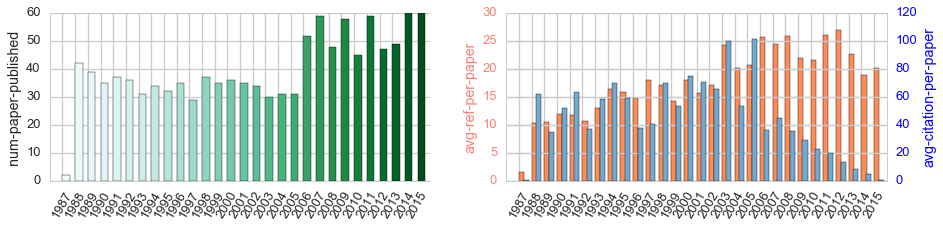

In [74]:
# data profile: # of papers published per year, citations per year

plt.figure(figsize=(15, 3))
cur_dpi=100
# # of papers over years; # of references and # of citations over years
# # of citings over years, w/wo venues; # of citing venues over years
# # of citations over publication years, w/wo venues; # of venues over years

bar_colrs1 = sns.color_palette("BuGn", len(paper_years))
bar_colrs2 = sns.color_palette("OrRd", len(paper_years))
bar_colrs3 = sns.color_palette("PuBu", len(paper_years))
mdx = int(len(bar_colrs1)/2) # index of the middle bar color
x_pos = [x+1 for x in range(len(paper_years))]

"""# papers per year"""

sns.set_context("talk", font_scale=1.)
sns.set_style("whitegrid")
sns.despine()

ax = plt.subplot(1, 2, 1)

rects1 = ax.bar(x_pos, np.array(paper_count), width=.6, color=bar_colrs1)
ax.set_ylabel('num-paper-published')
tk1 = plt.xticks(x_pos, paper_years, rotation=60) 

"""# of references and # of citations over years"""
ax2 = plt.subplot(1, 2, 2)

sns.set_style("whitegrid")
sns.despine()

rects2 = ax2.bar(x_pos, ref_pp, width=.4, color=bar_colrs2[mdx])

ax2a = ax2.twinx()
rects2a = ax2a.bar([x+.35 for x in x_pos], cit_pp, width=.4, color=bar_colrs3[mdx])

tk2 = plt.xticks([],[])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(paper_years, rotation=60)

ax2.set_ylabel('avg-ref-per-paper', color='salmon')
ax2a.set_ylabel('avg-citation-per-paper', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('salmon')
for tl in ax2a.get_yticklabels():
    tl.set_color('b') 

plt.savefig(os.path.join(plot_dir, conf.lower()+'_cnt_paper.png'), dpi=cur_dpi, transparent=True)    

[1, 315, 278, 290, 286, 268, 293, 402, 376, 372, 391, 450, 401, 489, 407, 450, 574, 515, 520, 1056, 1155, 1028, 1032, 821, 1306, 1107, 960, 948, 1027] [2, 117, 129, 129, 146, 117, 109, 156, 134, 143, 133, 183, 98, 159, 141, 135, 157, 112, 124, 280, 286, 217, 241, 151, 234, 162, 153, 188, 186]


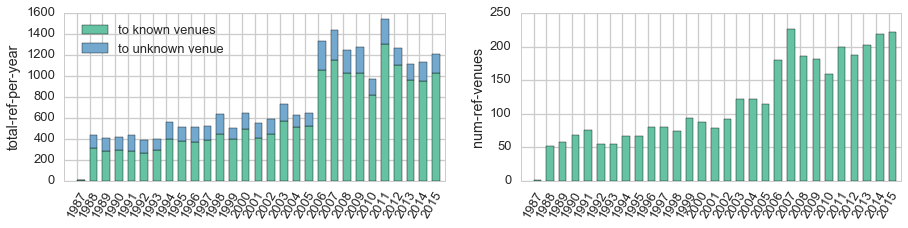

In [51]:
"""# of citings over years, w/wo venues; # of citing venues over years"""    
plt.figure(figsize=(15, 3))

ax3 = plt.subplot(1, 2, 1)
sns.set_context("talk", font_scale=1.)
sns.set_style("whitegrid")

citing_not_null = [] #np.zeros((1, len(years)), dtype=np.int)
citing_num_null = [] #np.zeros((len(years), 1), dtype=np.int)
cnt = 0 
for name, gf in df_citing.groupby(['PaperPubYear']):
    #print(gf.head())
    #print(len(gf), len ( gf['RefVenueID'][gf['RefVenueID'] != ''] ), len ( gf['RefVenueID'][gf['RefVenueID'] == ''] )) 
    citing_not_null.append( len ( gf['RefVenueID'][gf['RefVenueID'] != ''] ) )
    citing_num_null.append( len ( gf['RefVenueID'][gf['RefVenueID'] == ''] ) )
    
print(citing_not_null, citing_num_null)    

rects3a = ax3.bar(x_pos, citing_not_null, width=.6, color=bar_colrs1[mdx])
rects3b = ax3.bar(x_pos, citing_num_null, width=.6, color=bar_colrs3[mdx], bottom=citing_not_null)

tk3 = plt.xticks(x_pos, paper_years, rotation=60) 
ax3.set_ylabel('total-ref-per-year')
plt.legend((rects3a[0], rects3b[0]), 
           ('to known venues', 'to unknown venue'), bbox_to_anchor=(.45, 1))

ax4 = plt.subplot(1, 2, 2)
sns.set_style("whitegrid")

venue_counts = np.zeros( len(paper_years) )
for name, gf in df_citing[df_citing['RefVenueID'] != ''].groupby(['PaperPubYear']):
    idy = np.where(paper_years==name)
    if idy[0].size:
        venue_counts[idy] = len( gf['RefVenueID'].value_counts() )
    #venue_counts.append( len( gf['RefVenueID'].value_counts() ) )

rects4 = ax4.bar(x_pos, venue_counts, width=.6, color=bar_colrs1[mdx])

tk4 = plt.xticks(x_pos, paper_years, rotation=60)
ax4.set_ylabel('num-ref-venues')

plt.savefig(os.path.join(plot_dir, conf.lower()+'_cnt_ref.png'), dpi=cur_dpi, transparent=True)    

[0, 1950, 1034, 1314, 1737, 991, 1314, 1727, 1382, 916, 869, 1790, 1366, 1923, 1774, 1642, 2047, 1215, 2236, 1322, 1857, 1237, 1177, 779, 856, 466, 317, 189, 20] [1, 648, 337, 517, 604, 332, 489, 652, 522, 404, 314, 786, 502, 776, 687, 594, 947, 434, 912, 564, 779, 467, 506, 242, 294, 151, 95, 73, 5]
29 29


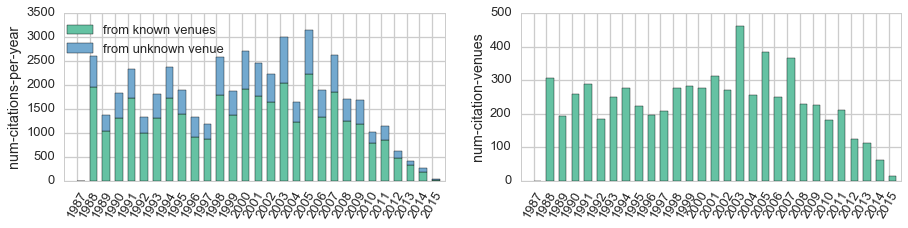

In [50]:
"""# of citations over publication years, w/wo venues; # of venues over years"""

plt.figure(figsize=(15, 3))

ax5 = plt.subplot(1, 2, 1)
sns.set_style("whitegrid")

citations_not_null = [] 
citations_num_null = [] 
for name, gf in df_cited.groupby(['RefPubYear']):
    #print(gf.head())
    # print(name, len(gf), len ( gf['PaperVenueID'][gf['PaperVenueID'] != ''] ), len ( gf['PaperVenueID'][gf['PaperVenueID'] == ''] )) 
    if name in paper_years:    
        citations_not_null.append( len ( gf['PaperVenueID'][gf['PaperVenueID'] != ''] ) )
        citations_num_null.append( len ( gf['PaperVenueID'][gf['PaperVenueID'] == ''] ) )
    
print(citations_not_null, citations_num_null)
print(len(citations_not_null), len(citations_num_null))


rects5a = ax5.bar(x_pos, citations_not_null, width=.6, color=bar_colrs1[mdx])
rects5b = ax5.bar(x_pos, citations_num_null, width=.6, color=bar_colrs3[mdx], bottom=citations_not_null)

tk5 = plt.xticks(x_pos, paper_years, rotation=60) 
ax5.set_ylabel('num-citations-per-year')
plt.legend((rects5a[0], rects5b[0]), 
           ('from known venues', 'from unknown venue'), bbox_to_anchor=(.45, 1))

ax6 = plt.subplot(1, 2, 2)
sns.set_style("whitegrid")

venue_counts = np.zeros( len(paper_years) )
for name, gf in df_cited[df_cited['PaperVenueID'] != ''].groupby(['RefPubYear']):
    idy = np.where(paper_years==name)
    if idy[0].size:
        venue_counts[idy] = len( gf['PaperVenueID'].value_counts() )
    #if name in paper_years:    
    #    venue_counts.append( len( gf['PaperVenueID'].value_counts() ) )

rects6 = ax6.bar(x_pos, venue_counts, width=.6, color=bar_colrs1[mdx])

tk6 = plt.xticks(x_pos, paper_years, rotation=60)
ax6.set_ylabel('num-citation-venues')

plt.savefig(os.path.join(plot_dir, conf.lower()+'_cnt_citation.png'), dpi=cur_dpi, transparent=True)    

1171 paper papers from 1979 to 2015, citing 22040 others, avg 18.82 references per paper


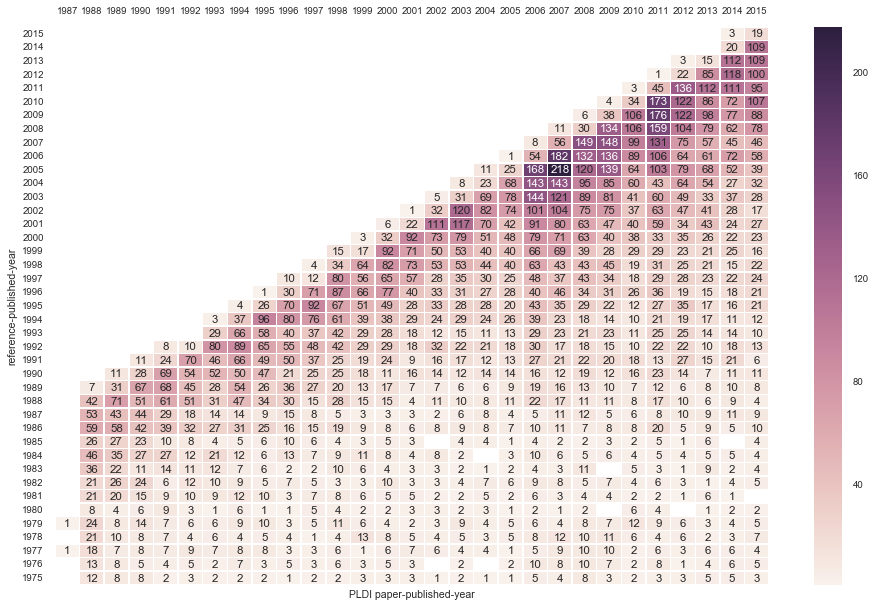

In [52]:
print('{} paper papers from {} to {}, citing {} others, avg {:0.2f} references per paper'.format(
        len(df_paper), df_paper['PubYear'].min(), df_paper['PubYear'].max(), len(df_citing), len(df_citing)/len(df_paper)))
grouped_citing = df_citing.groupby(['PaperPubYear'], sort=True)
grouped_citing.count()
len(grouped_citing)

refpubyear_count = pd.DataFrame(data=None, index=np.unique(df_citing['RefPubYear'] ), 
                                    columns=paper_years, dtype='int32')
for name, gf in grouped_citing:
    if name in paper_years:    
        refpubyear_count[name] = gf['RefPubYear'].value_counts(sort=True)
    #print("{}: {} references across {} years".format(name, len(gf), len(gf['RefPubYear'].value_counts())) )

plt.figure(figsize=(16, 10))
sns.set_context("poster", font_scale=0.6) #rc={"lines.linewidth": 2.5}

""" # the view of everthing
sns.heatmap(refpubyear_count, linewidths=.5, yticklabels=3)
ax.xaxis.tick_top()
ax.invert_yaxis()
sns.axlabel(conf + ' paper-published-year', 'reference-published-year')
"""

# the subset of reference years
ax = sns.heatmap(refpubyear_count.loc[1975:2015], linewidths=.5, annot=True, fmt=".0f") # annot=True, fmt="d", 
ax.xaxis.tick_top()
ax.invert_yaxis()
sns.axlabel(conf + ' paper-published-year', 'reference-published-year')

plt.savefig(os.path.join(plot_dir, conf.lower()+'_year_ref.png'), transparent=True)


1171 paper papers from 1979 to 2015, cited 49083 time, avg 41.92 cites per paper


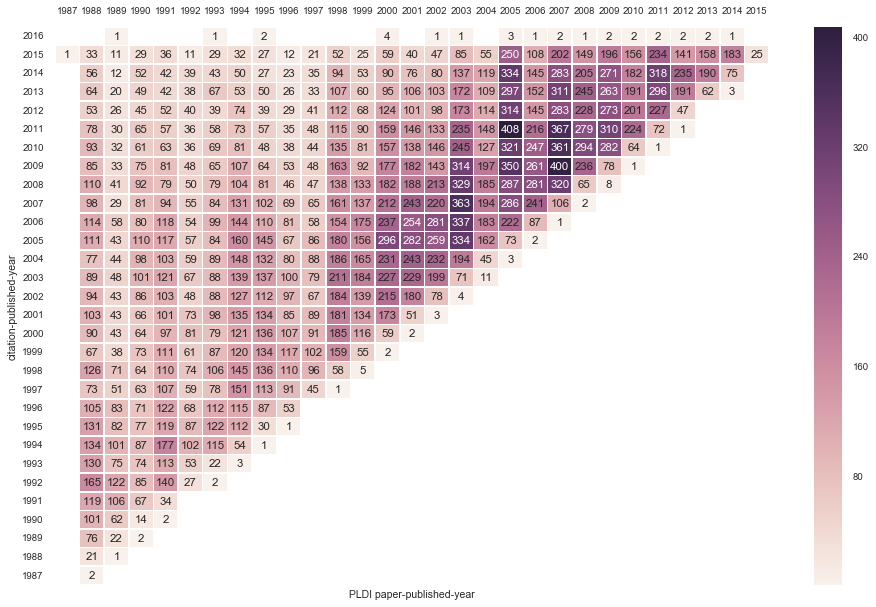

In [53]:
print('{} paper papers from {} to {}, cited {} time, avg {:0.2f} cites per paper'.format(
        len(df_paper), df_paper['PubYear'].min(), df_paper['PubYear'].max(), len(df_cited), len(df_cited)/len(df_paper)))
grouped_cited = df_cited.groupby(['RefPubYear'], sort=True)
#print( grouped_cited.count() )
#len(grouped_cited)

cite_pubyear_count = pd.DataFrame(data=None, index=np.unique(df_cited['PaperPubYear'] ), 
                                    columns=paper_years, dtype='int32')
for name, gf in grouped_cited:
    if name in paper_years:    
        cite_pubyear_count[name] = gf['PaperPubYear'].value_counts(sort=True)
    #print("{}: {} citations across {} years".format(name, len(gf), len(gf['PaperPubYear'].value_counts())) )
 
plt.figure(figsize=(16, 10))
sns.set_context("poster", font_scale=0.6) #rc={"lines.linewidth": 2.5}

ax = sns.heatmap(cite_pubyear_count.loc[1975:2016], linewidths=.5, annot=True, fmt=".0f") # annot=True, fmt="d", 
sns.axlabel(conf + ' paper-published-year', 'citation-published-year')
ax.xaxis.tick_top()
ax.invert_yaxis()

plt.savefig(os.path.join(plot_dir, conf.lower()+'_year_citation.png'), transparent=True)


67 top-50 venues, union of reference and citations.
{'SIGMETRICS-c': 1.4210357791029298, 'Science of Computer Pro..-j': 0.5010741833030853, 'Communications of The ACM-j': 11.513571234119784, 'Electronic Notes in The..-j': 0.37013790087023846, 'ICFP-c': 2.1682624000319097, 'SOSP-c': 3.165416224360511, 'ACM Trans on Architectu..-j': 0.06463577855566037, 'Higher-order and Symbol..-j': 1.6140615894370536, 'HPCA-c': 0.8907985480943739, 'LCPC-c': 0.46085657533160085, 'ACM Computing Surveys-j': 1.0148337889682741, 'ASE-c': 0.5809555748441568, 'ISSTA-c': 0.5418171245593174, 'PASTE-c': 0.6426158680282796, 'IEEE Trans on Computers-j': 1.481634319789622, 'HiPC-c': 0.3143994875627202, 'APLAS-c': 0.5233441470054447, 'OSDI-c': 2.675848351833875, 'ASPLOS-c': 1.0906301339228117, 'CASES-c': 0.2145271732796084, 'J. the ACM-j': 7.332792926386614, 'PACT-c': 0.7581264239101054, 'S&P-c': 1.9554114470364303, 'J. Systems and Software-j': 0.1961603020415072, 'ICPP-c': 0.6680989110707805, 'SPAA-c': 1.4773144238

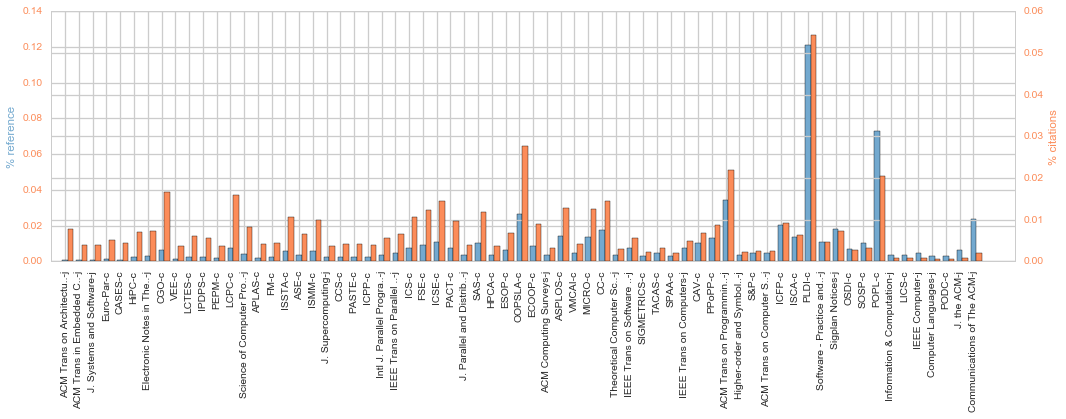

In [84]:
""" refs and citation data frames
PaperID     RefID  PaperPubYear  PaperConfID  RefPubYear RefVenueID
0  01C7AF88  5DF47FD5          2014      4332078        2005           
1  0419D273  69802989          2013      4332078        1983           
2  04C8255A  707FA05D          2011      4332078        2008   46A355BA
3  06E27F4E  5D781F7D          2014      4332078        2000    5686292
4  07E16ECA  5ACD83EA          2012      4332078        2005   4332078E

PaperID     RefID  RefPubYear  RefConfID  PaperPubYear PaperVenueID
0  0007A307  6F46CC0D        2000    4332078          2003             
1  001D62B0  5C4CC440        2002    4332078          2014     0140E2D3
2  002545D4  685D7FC2        1999    4332078          2005             
3  002E73A6  6978437E        2007    4332078          2009             
4  004344D3  5CCE3A13        1990    4332078          1991             

goal of this sec: groupby venue and count
"""

topK = 50 
numRef = len(df_citing)
numCite = len(df_cited)

# figure out the top venues for both ref and citations
gv_citing = df_citing.groupby(['RefVenueID'], sort=True)
venue_ref_cnt = gv_citing['PaperID'].count().sort_values(ascending=False)
allvenue_ref = [s for s in venue_ref_cnt.index if len(s)]

gv_cited = df_cited.groupby(['PaperVenueID'], sort=True)
venue_citation_cnt = gv_cited['PaperID'].count().sort_values(ascending=False)
allvenue_citation = [s for s in venue_citation_cnt.index if len(s)]

venue_topK = list(set(allvenue_ref[:topK] + allvenue_citation[:topK]))
print('{} top-{} venues, union of reference and citations.'.format(len(venue_topK), topK) )

# build a graph structure for the above

venueG = nx.DiGraph()
refG = nx.DiGraph()
citeG = nx.DiGraph()

venue_metric = dict()
venue_ref = dict()
venue_citation = dict()

"""
    construct venue graphs, and 
    compute the in/out citation metric 
"""
for v in venue_topK:
    vname = id2display[v]
    r = venue_ref_cnt[v]
    refG.add_edge(conf, vname, weight= int(r) )
    venueG.add_edge(conf, vname, weight= float(r/numRef) )
    
    c = venue_citation_cnt[v]
    citeG.add_edge(vname, conf, weight= int(c) )
    venueG.add_edge(vname, conf, weight= float(c/numCite) )
    
    venue_ref[vname] = float(r/numRef)
    venue_citation[vname] = float(c/numCite)
    venue_metric[vname] = float(r/numRef) / float(c/numCite)

nx.set_node_attributes(venueG, 'citation_out', venue_ref)
nx.set_node_attributes(venueG, 'citation_in', venue_citation)
nx.set_node_attributes(venueG, 'citation_flow', venue_metric)
print(venue_metric)

nx.write_graphml(venueG, os.path.join(data_dir, 'citeG.'+conf+'.graphml'))
nx.write_gexf(venueG, os.path.join(data_dir, 'citeG.'+conf+'.gexf'))

# generate bar graphs visualizing overall in/out citation volume
plt.figure(figsize=(15, 6))
sns.set_context("talk", font_scale=0.8) #rc={"lines.linewidth": 2.5}
sns.set_style("whitegrid")
sns.despine()

isort = list(np.argsort([venue_metric[id2display[v]] for v in venue_topK]))
sorted_name_list = [id2display[venue_topK[i]] for i in isort]
x_venues = [x+1 for x in range(len(venue_topK))]

ax2 = plt.subplot(1,1,1)

vbar = ax2.bar([x-.2 for x in x_venues], [venue_ref[v] for v in sorted_name_list], 
                width=.4, color=bar_colrs3[mdx])

ax2a = ax2.twinx()
vbara = ax2a.bar([x+.2 for x in x_venues], [venue_citation[v] for v in sorted_name_list], 
                   width=.4, color=bar_colrs2[mdx])

tk2 = plt.xticks([],[])
ax2.set_xticks(x_venues)
ax2.set_xticklabels(sorted_name_list, rotation=90)

ax2.set_ylabel('% references', color=bar_colrs3[mdx])
ax2a.set_ylabel('% citations', color=bar_colrs2[mdx])
for tl in ax2.get_yticklabels():
    tl.set_color(bar_colrs2[mdx])
for tl in ax2a.get_yticklabels():
    tl.set_color(bar_colrs2[mdx]) 
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, conf.lower()+'_venue_bar.png'), transparent=True)

In [85]:
# accumulate counts for refrences
refvenue_count = pd.DataFrame(data=None, dtype='int32', index = allvenue_ref, columns = paper_years)

for name, gf in grouped_citing:
    if name in paper_years:    
        refvenue_count[name] = gf['RefVenueID'].value_counts(sort=True)


# accumulate counts for citations
citevenue_count = pd.DataFrame(data=None, index = allvenue_citation, columns = paper_years, dtype='int32')
for name, gf in grouped_cited:
    if name in paper_years:    
        citevenue_count[name] = gf['PaperVenueID'].value_counts(sort=True)


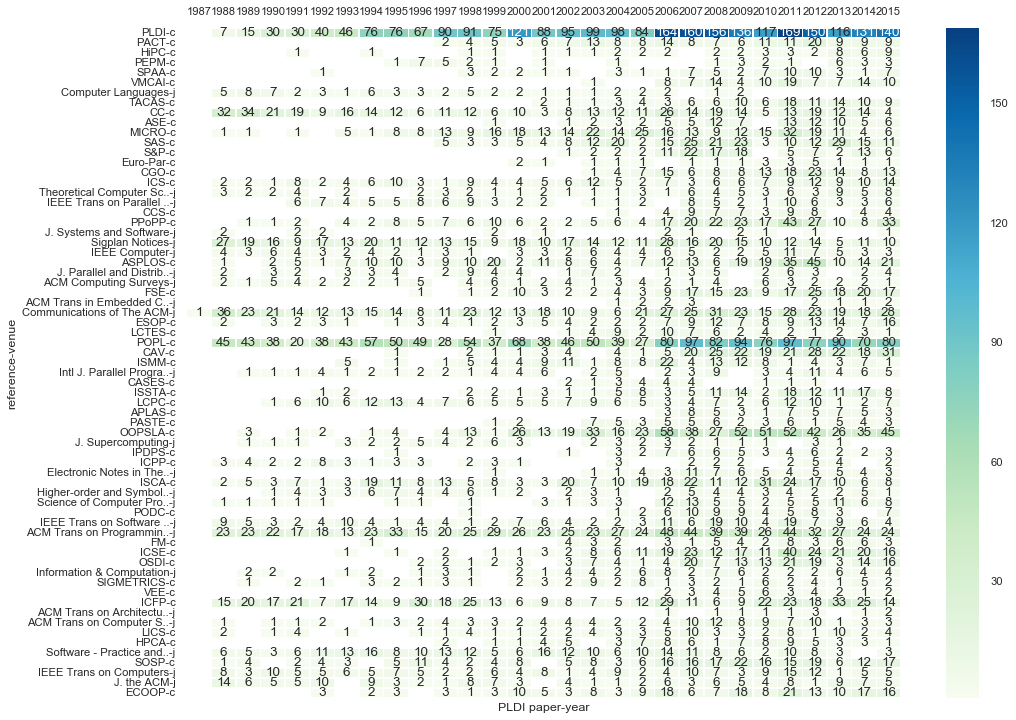

In [86]:
plt.figure(figsize=(16, 12))
sns.set_context("poster", font_scale=0.7)

ax = sns.heatmap(refvenue_count.loc[venue_topK], linewidths=.5, annot=True, fmt=".0f", cmap="GnBu") 
ax.xaxis.tick_top()
sns.axlabel(conf + ' paper-year', 'reference-venue')
venue_name = [id2display[v] for v in venue_topK]
yt = ax.set_yticklabels(venue_name[::-1])

plt.savefig(os.path.join(plot_dir, conf.lower()+'_venue_ref.png'), transparent=True)

In [141]:
# now the citing articles

dfx_cited = df_cited.merge(df_venue, left_on='PaperVenueID', right_on='VenueID', how='left')
dfx_cited.drop('VenueID', axis=1, inplace=True)
dfx_cited = dfx_cited.rename(columns = {'VenueName':'PaperVenueName'})

print( dfx_cited.head() )

is_empty = dfx_cited['PaperVenueID'] == ''
print( is_empty.value_counts() ) 

dfx_cited_valid = dfx_cited[dfx_cited['PaperVenueID'] != '']
dfx_cited_valid.tail()

    PaperID     RefID  RefPubYear  RefConfID  PaperPubYear PaperVenueID  \
0  0007A307  6F46CC0D        2000    4332078          2003                
1  001D62B0  5C4CC440        2002    4332078          2014     0140E2D3   
2  002545D4  685D7FC2        1999    4332078          2005                
3  002E73A6  6978437E        2007    4332078          2009                
4  004344D3  5CCE3A13        1990    4332078          1991                

                    PaperVenueName  
0                              NaN  
1  Science of Computer Programming  
2                              NaN  
3                              NaN  
4                              NaN  
True     33857
False    31518
Name: PaperVenueID, dtype: int64


,PaperID,RefID,RefPubYear,RefConfID,PaperPubYear,PaperVenueID,PaperVenueName
65364,7088A8B7,6CD63D17,1989,4332078,2003,0880543B,ACM Transactions on Software Engineering and M...
65368,709BBDB8,6E29E827,2010,4332078,2010,430D9705,ISSTA
65370,70A776CF,6E2557C5,1994,4332078,2006,041D69C4,Journal of Embedded Computing
65371,70AD3DA1,67174FC2,1997,4332078,2012,0965DDD6,IEEE Transactions on Computers
65372,70ADE0A5,69AF8833,2002,4332078,2006,430D9705,ISSTA


In [142]:
grouped_cited = dfx_cited_valid.groupby(['RefPubYear'], sort=True)

cited_venue_count = pd.DataFrame(data=None, index = venue_name, 
                                    columns=np.unique(dfx_cited_valid['RefPubYear']), dtype='int32')
for name, gf in grouped_cited:
    #grouped_citing.RefPubYear
    cited_venue_count[name] = gf['PaperVenueName'].value_counts(sort=True)
    print("{}: {} citiations across {} venues".format(name, len(gf), cited_venue_count[name].notnull().sum() ) )
    

1984: 1 citiations across 0 venues
1987: 1 citiations across 0 venues
1988: 2471 citiations across 0 venues
1989: 1159 citiations across 0 venues
1990: 1540 citiations across 0 venues
1991: 1669 citiations across 0 venues
1992: 894 citiations across 0 venues
1993: 1187 citiations across 0 venues
1994: 1634 citiations across 0 venues
1995: 1436 citiations across 0 venues
1996: 825 citiations across 0 venues
1997: 775 citiations across 0 venues
1998: 1468 citiations across 0 venues
1999: 1121 citiations across 0 venues
2000: 1614 citiations across 0 venues
2001: 1562 citiations across 0 venues
2002: 1668 citiations across 0 venues
2003: 1988 citiations across 0 venues
2004: 965 citiations across 0 venues
2005: 1966 citiations across 0 venues
2006: 1140 citiations across 0 venues
2007: 1473 citiations across 0 venues
2008: 935 citiations across 0 venues
2009: 759 citiations across 0 venues
2010: 420 citiations across 0 venues
2011: 454 citiations across 0 venues
2012: 192 citiations acros

In [144]:
total_cnt = dfx_cited_valid.groupby(['PaperVenueName']).count()['PaperID'].copy()
total_cnt.sort_values(ascending=False, inplace=True)
#print(total_cnt.head(25), total_cnt.tail())

topK = 50
venue_list = list(total_cnt.index)[:topK]
print(venue_list)

sns.set_context("poster", font_scale=0.7)
plt.figure(figsize=(16, 10))
ax = sns.heatmap(cited_venue_count.loc[venue_list], linewidths=.5, annot=True, fmt=".0f", cmap="GnBu") 
ax.xaxis.tick_top()
venue_name = [name2display[v] for v in venue_list]
yt = ax.set_yticklabels(venue_name[::-1])
sns.axlabel(conf + ' paper-year', 'reference-venue')

plt.savefig(os.path.join(plot_dir, conf.lower()+'_citation_venue.png'), transparent=True)

['PLDI', 'ACM Transactions on Programming Languages and Systems', 'CC', 'ASPLOS', 'LCPC', 'FSE', 'ICSE', 'POPL', 'Sigplan Notices', 'ICFP', 'PACT', 'IEEE Transactions on Software Engineering', 'ICS', 'Software - Practice and Experience', 'PPoPP', 'Science of Computer Programming', 'International Journal of Parallel Programming', 'ECOOP', 'IEEE Transactions on Parallel and Distributed Systems', 'OOPSLA', 'CoRR', 'ASE', 'CAV', 'MICRO', 'IEEE Transactions on Computers', 'ISMM', 'ACM Sigarch Computer Architecture News', 'Euro-Par', 'SCAM', 'ESOP', 'ISSTA', 'Journal of Systems and Software', 'APLAS', 'Operating Systems Review', 'Journal of Parallel and Distributed Computing', 'The Journal of Supercomputing', 'ACM Transactions on Software Engineering and Methodology', 'ICPP', 'HPCA', 'ICSM', 'ACM Transactions in Embedded Computing Systems', 'Proceedings of the IEEE', 'PASTE', 'International Journal on Software Tools for Technology Transfer', 'S&P', 'ACM Computing Surveys', 'IEEE Transactions

KeyError: "None of [['PLDI', 'ACM Transactions on Programming Languages and Systems', 'CC', 'ASPLOS', 'LCPC', 'FSE', 'ICSE', 'POPL', 'Sigplan Notices', 'ICFP', 'PACT', 'IEEE Transactions on Software Engineering', 'ICS', 'Software - Practice and Experience', 'PPoPP', 'Science of Computer Programming', 'International Journal of Parallel Programming', 'ECOOP', 'IEEE Transactions on Parallel and Distributed Systems', 'OOPSLA', 'CoRR', 'ASE', 'CAV', 'MICRO', 'IEEE Transactions on Computers', 'ISMM', 'ACM Sigarch Computer Architecture News', 'Euro-Par', 'SCAM', 'ESOP', 'ISSTA', 'Journal of Systems and Software', 'APLAS', 'Operating Systems Review', 'Journal of Parallel and Distributed Computing', 'The Journal of Supercomputing', 'ACM Transactions on Software Engineering and Methodology', 'ICPP', 'HPCA', 'ICSM', 'ACM Transactions in Embedded Computing Systems', 'Proceedings of the IEEE', 'PASTE', 'International Journal on Software Tools for Technology Transfer', 'S&P', 'ACM Computing Surveys', 'IEEE Transactions on Computer-Aided Design of Integrated Circuits and Systems', 'Concurrency and Computation: Practice and Experience', 'VEE', 'Journal of Functional Programming']] are in the [index]"

In [94]:
cited_venue_count.index #loc[venue_list]

Index(['SIGIR-c', 'WWW-c', 'KDD-c', 'WSDM-c', 'CIKM-c', 'NIPS-c', 'CoRR-j',
       'ICML-c', 'CHI-c', 'ICDM-c', 'ACM Trans on Informatio..-j', 'ACL-c',
       'Communications of The ACM-j', 'J. Machine Learning Res..-j', 'EMNLP-c',
       'Information Processing ..-j', 'J. the Association for ..-j', 'AAAI-c',
       'J. the ACM-j', 'VLDB-c', 'Proc. The Vldb Endowment-j',
       'Proc. the Nal Academy o..-j', 'SIGMOD-c', 'Sigir Forum-j', 'ICWSM-c',
       'Information Retrieval-j', 'WI-c', 'IEEE Trans on Knowledge..-j',
       'Machine Learning-j', 'SODA-c', 'J. the American Statist..-j', 'UAI-c',
       'EC-c', 'STOC-c', 'World Wide Web-j', 'Technometrics-j',
       'Sigkdd Explorations-j', 'NAACL-c', 'IEEE Trans on Pattern A..-j',
       'RecSys-c', 'IEEE Computer-j', 'MM-c', 'Science-j',
       'Computer Networks-j', 'Physical Rev E-j',
       'Computer Networks and I..-j', 'ACM Computing Surveys-j', 'COLING-c',
       'Foundations and Trends ..-j', 'Data Mining and Knowled..-j'],
  

In [43]:
import networkx as nx

topK = 25

""" generate citation venue graph """
citation_venue_cnt = dfx_cited_valid.groupby(['PaperVenueName']).count()['PaperID'].copy()
citation_venue_cnt.sort_values(ascending=False, inplace=True)
citeG = nx.DiGraph()

#for i in range(topK):
for v, c in zip(list(citation_venue_cnt.head(25).index), list(citation_venue_cnt.head(25))):
    citeG.add_edge(v, 'WSDM', weight= int(c) )

nx.write_graphml(citeG, os.path.join(data_dir, 'citeG.graphml'))

""" generate reference venue graph """ 
ref_venue_cnt = dfx_citing_valid.groupby(['RefVenueName']).count()['PaperID'].copy()
ref_venue_cnt.sort_values(ascending=False, inplace=True)
refG = nx.DiGraph()

#for i in range(topK):
for v, c in zip(list(ref_venue_cnt.head(topK).index), list(ref_venue_cnt.head(topK))):
    refG.add_edge('WSDM', v, weight=int(c) )

nx.write_graphml(citeG, os.path.join(data_dir, 'refG.graphml'))
